### Opinion Lexicons
In the previous part, where we were using a simple pipeline to create a twitter sentiment analysis, it was created a pipeline with tokens and tested the use of different tokenizer as well as the use of Bigrams and Trigrams. 

The best result so far has been the use of informal tokenizer with removal of very common stop words like articles.

In this notebook we are going to make experiments related to the opinion lexicons and try to make the best use of them. Opinion lexicons are the ones that basically have one value associated with the polarity of each word.

In [1]:
%matplotlib inline
from IPython.display import display

import libs.files as fh
import libs.parse as p
import libs.pipeline as pipe
import libs.utils as u
import libs.resources as r

import numpy as np
import matplotlib.pyplot as plt
import nltk
import scipy as scy
import cPickle
import pandas as pd
from os import path

plt.style.use('seaborn-muted')

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection

In [2]:
# read the information
OUTPUT_DIR = '../3-Output/'
MODEL_OUT_DIR = '../6-Models'
CREATE_TOKENS_FILES = True
PROCESS_DIR = '../2-Processed'

# read the config file
cfg = fh.read_config_file("all.yaml")

# read the train file
file_name = "../1-Input/trainingData-B.tsv"
file_type = 'B'
train_feat, labels, train_tweets = pipe.create_features(file_name, file_type, cfg)

# read the dev file
file_name = "../1-Input/devData-B.tsv"
file_type = 'B'
dev_feat, dev_labels, dev_tweets = pipe.create_features(file_name, file_type, cfg)

# read the test file
file_name = "../1-Input/testData-B.tsv"
file_type = 'B'
test_feat, gold, test_tweets = pipe.create_features(file_name, file_type, cfg)

Read 9683 rows from ../1-Input/trainingData-B.tsv
Read 1653 rows from ../1-Input/devData-B.tsv
Read 3812 rows from ../1-Input/testData-B.tsv


Creating the same dataset used on the previous pipeline

In [3]:
# random seed for all the operations
rnd_seed = 9000

# convert the list into and array that can be indexed
labels = np.array(labels)
dev_labels = np.array(dev_labels)
gold = np.array(gold)

# create the cleaned the tweets
train_clean, dev_clean, vect = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=pipe.tokenize_clean_raw, stop_words=pipe.stop_words)
train_data, dev_data, selec = pipe.auto_select_features(pipe.chi2, 5, train_clean, labels, dev_clean, dev_labels)

train shape: (8171, 18094)
dev shape: (1405, 18094)
Final shape (8171, 927) (1405, 927)


In [4]:
# create the test dataset as well
test_clean = vect.transform(test_tweets)
test_data = selec.transform(test_clean)
print test_data.shape

(3239, 927)


In [5]:
base_scores = pipe.run_multiple_class(train_data, labels, dev_data, dev_labels, rnd_seed=rnd_seed)

In [6]:
pipe.pprint_results(base_scores)

In [7]:
# save the dataset for future use
if CREATE_TOKENS_FILES:
    pipe.dump_data(train_data, 'train_base_data.pck')
    pipe.dump_data(dev_data, 'dev_base_data.pck')
    pipe.dump_data(test_data, 'test_base_data.pck')
    pipe.dump_data(labels, 'labels.pck')
    pipe.dump_data(dev_labels, 'dev_labels.pck')
    pipe.dump_data(gold, 'gold.pck')

And now manually tokenizing to later process them with the lexicons

In [8]:
# using negated tokens
train_neg_tokens = [pipe.tokenize_negate_clean_raw(t) for t in train_tweets]
dev_neg_tokens = [pipe.tokenize_negate_clean_raw(t) for t in dev_tweets]
test_neg_tokens = [pipe.tokenize_negate_clean_raw(t) for t in test_tweets]

In [9]:
# not using negated tokens
train_tokens = [pipe.tokenize_clean_raw(t) for t in train_tweets]
dev_tokens = [pipe.tokenize_clean_raw(t) for t in dev_tweets]
test_tokens = [pipe.tokenize_clean_raw(t) for t in test_tweets]

In [10]:
ids = [69, 72, 78, 497, 623, 1196, 6181]
rnd_data = np.array(train_tokens)[ids]
rnd_data

array([ [u'"', '@MENTION', u':', u'damn', u'next', u'saturday', u'tho', u'"', u'niggas', u'was', u'trynna', u'get', u'shit', u'over', u'#early'],
       [u'business', u"leader's", u'award', u'ceremony', u'will', u'held', u'during', '@MENTION', u'annual', u'meeting', u'davos', 'NUMBER', u'january', 'NUMBER', u'!', 'HTTP'],
       [u'calling', u'all', u'voters', u',', u"i'm", u'calling', u'nevada', u',', u'florida', u',', u'ohio', u',', u'tuesday', u'night', u'is', u'night', u'u', u'guys', u'will', u'i', u'repeat', u'will', u'shine', u'president', u'lets', u'go', u'!'],
       [u'#longharryimagine', u'#imagine', u"it's", u'friday', u'night', u'you', u'find', u'yourself', u'watching', u'notebook', u',', u'again', u'.', u'you', u'just', u'(', u'cont', u')', 'HTTP'],
       ['@MENTION', u'movie', u'day', u'some', u"grammy's", u'hot', u'chocolate', u'tomorrow', u'...', u'#pleaseohplease'],
       ['@MENTION', u'lololololololol', u'im', u'sg', u'bucks', u'so', u'im', u'good', u'team', u',', u

In [16]:
ids = [69, 72, 78, 497, 623, 1196, 2]
rnd_data = np.array(train_neg_tokens)[ids]
rnd_data

array([ [u'"', '@MENTION', u':', u'damn', u'next', u'saturday', u'tho', u'"', u'niggas', u'was', u'trynna', u'get', u'shit', u'over', u'#early'],
       [u'business', u"leader's", u'award', u'ceremony', u'will', u'held', u'during', '@MENTION', u'annual', u'meeting', u'davos', 'NUMBER', u'january', 'NUMBER', u'!', 'HTTP'],
       [u'calling', u'all', u'voters', u',', u"i'm", u'calling', u'nevada', u',', u'florida', u',', u'ohio', u',', u'tuesday', u'night', u'is', u'night', u'u', u'guys', u'will', u'i', u'repeat', u'will', u'shine', u'president', u'lets', u'go', u'!'],
       [u'#longharryimagine', u'#imagine', u"it's", u'friday', u'night', u'you', u'find', u'yourself', u'watching', u'notebook', u',', u'again', u'.', u'you', u'just', u'(', u'cont', u')', 'HTTP'],
       ['@MENTION', u'movie', u'day', u'some', u"grammy's", u'hot', u'chocolate', u'tomorrow', u'...', u'#pleaseohplease'],
       ['@MENTION', u'lololololololol', u'im', u'sg', u'bucks', u'so', u'im', u'good', u'team', u',', u

First, check which lexicons are available

In [10]:
[lex for lex in r.lexs if lex.opinion]

In [45]:
def run_lex_test(lex, verbose=True, select=False, percent=5, negate=False, use_best_params=True, **params):
    # create lexicon features
    if negate:
        train_sent = lex.process_lex(train_neg_tokens, **params)
        dev_sent = lex.process_lex(dev_neg_tokens, **params)
    else:
        train_sent = lex.process_lex(train_tokens, **params)
        dev_sent = lex.process_lex(dev_tokens, **params)
    
    if verbose:
        print train_sent[:3]
        
    # select the feature if needed
    create_vec=True
    if select:
        train_sent, dev_sent, _, vect = pipe.create_lex_vec(train_sent, dev_sent)
#         if verbose == True:
#             print vect.get_feature_names()[:3]
#             print train_sent[0]
        train_sent, dev_sent, _ = pipe.auto_select_features(pipe.mutual_info_classif, percent, 
                                                            train_sent, labels, 
                                                            dev_sent, dev_labels)
        create_vec = False
        
    if verbose:
        if create_vec:
            # not a vector, just check if thre is a dictionary with the features
            num_tw_found_train = float(np.array([ 1 for t in train_sent if t]).sum())
            num_tw_found_dev = float(np.array([ 1 for t in dev_sent if t]).sum())
        else:
            # it is an vector. For each tweet sum the number of tokens found
            train_tmp = train_sent.todense()
            dev_tmp = dev_sent.todense()
            num_tw_found_train = float(np.array([ 1 for t in train_tmp if t.sum()]).sum())
            num_tw_found_dev = float(np.array([ 1 for t in dev_tmp if t.sum()]).sum())
        
        len_train = len(train_tokens)
        len_dev = len(dev_tokens)
        per_train = num_tw_found_train/len_train
        per_dev = num_tw_found_dev/len_dev
        print('num_tw_found_train, len_train, num_tw_found_dev, len_dev',num_tw_found_train, len_train, num_tw_found_dev, len_dev)
        print('Coverage train: {0:.2%}, test: {0:.2%}'.format(per_train, per_dev))
    
    # create training and dev datasets
    X ,X_dev = pipe.join_lex_features(train_data, train_sent,
                                      dev_data, dev_sent,
                                      create_vec=create_vec)


    # train the algorithms
    ret = pipe.run_multiple_class(X, labels, X_dev, dev_labels, rnd_seed=rnd_seed, use_best_params=use_best_params)
    return ret

In [11]:
def test_percentile(lex, percentile, test_name, negate=False, **features):
    tmp = run_lex_test(lex, verbose=False, select=True, percent=percentile, negate=negate, **features)
    tmp = tmp[['train score', '{} score'.format(test_name)]]
    return tmp.add_prefix(str(percentile)+' ')

    
def compare_percentiles(lex, percentiles = [5,10,15,30, 100], test_name='dev', negate=False, **features):
    
    def highlight_max(s):
        '''
        highlight the maximum in a Series in bold.
        '''
        is_max = s == s.max()
        css = ['font-weight: bold' if v else '' for v in is_max]
        return css
    
    def highlight_top3(s):
        '''
        highlight the top3 in a Series in bold.
        '''
        # colors for the background an create an ordered vector
        shades = [200, 220, 247]
        ordered = s.sort_values(ascending=False)
        ordered.reset_index(inplace=True, drop=True)
        idx = pd.Index(ordered)
        
        # paint the Background accordingly
        css = ['background-color: rgb({color},{color},{color})'\
               .format(color=shades[idx.get_loc(v)]) \
               if idx.get_loc(v)<3 else '' for v in s]
        return css

    
    # get a first df
    df = test_percentile(lex, percentiles[0], test_name, negate=negate, **features)
    for perc in percentiles[1:]:
        tmp = test_percentile(lex, perc, test_name, negate=negate, **features)
        df = pd.concat([df, tmp], axis = 1)

    return df.style.apply(highlight_max).apply(highlight_top3)

### Bing Liu's Lexicon
Bing Liu was one of the first lexicons created. It is based on the WordNet. On the paper (Hu & Liu 2004), they basically summed the total of negative and positive tokens and the winner takes is all. That means that if >0, positive, if <0, negative. 

As the paper has a objective of assessing polarities of features of a product, if this sentence was neutral, he would assign the previous sentence polarity to it. This will not be the case here. A sum of 0 will mean neutral.

A small sample of the words found in the dictionary

In [12]:
# print a small example
r.bing.df.sample(10)

,BING
limits,-1
dumping,-1
quitter,-1
stiff,-1
abort,-1
inexorable,-1
addicts,-1
inflammatory,-1
outcast,-1
unpopular,-1


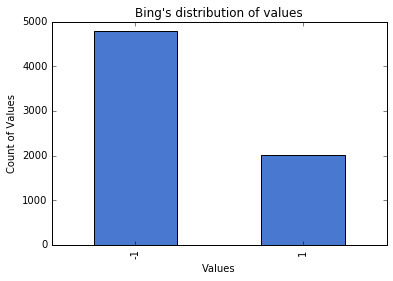

In [13]:
def print_lex_hist(df, title=''):
    plt.figure()
    a = df.value_counts().plot.bar(grid=False)
    a.set_title(title)
    a.set_xlabel("Values")
    a.set_ylabel("Count of Values")
print_lex_hist(r.bing.df['BING'], 'Bing\'s distribution of values')

As it can be seen, most of the words in the dictionary are negative.

Examining how Bing would work with some example sentences:

In [14]:
print('(Tweet, Sentiment)')
print( zip(train_tweets[:3],labels[:3]))

(Tweet, Sentiment)
[(u"Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)", 1), (u'Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.', -1), (u"its not that I'm a GSP fan, i just hate Nick Diaz. can't wait for february.", -1)]


In [15]:
print(train_neg_tokens[:3])

[[u'gas', u'by', u'my', u'house', u'hit', u'$3.39', u'!!!!', u"i'm", u'going', u'chapel', u'hill', u'sat', u'.', u':)'], [u'theo', u'walcott', u'is', u'still', u'shit', u',', u'watch', u'rafa', u'johnny', u'deal', u'him', u'saturday', u'.'], [u'its', u'not', u'NEG_that', u"NEG_i'm", u'NEG_a', u'NEG_gsp', u'NEG_fan', u',', u'i', u'just', u'hate', u'nick', u'diaz', u'.', u"can't", u'NEG_wait', u'NEG_for', u'NEG_february', u'.']]


In [16]:
print(train_tokens[:3])

[[u'gas', u'by', u'my', u'house', u'hit', u'$3.39', u'!!!!', u"i'm", u'going', u'chapel', u'hill', u'sat', u'.', u':)'], [u'theo', u'walcott', u'is', u'still', u'shit', u',', u'watch', u'rafa', u'johnny', u'deal', u'him', u'saturday', u'.'], [u'its', u'not', u"i'm", u'gsp', u'fan', u',', u'i', u'just', u'hate', u'nick', u'diaz', u'.', u"can't", u'wait', u'february', u'.']]


In [17]:
lex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol': True
}

In [18]:
train_sent_bing = r.bing.process_lex(train_tokens, **lex_features)
dev_sent_bing = r.bing.process_lex(dev_tokens, **lex_features)
test_sent_bing = r.bing.process_lex(test_tokens, **lex_features)
print(train_sent_bing[:3])

[{'BING_negamt': 0, 'BING_avg': 0.0, 'BING_max': 0.0, 'BING_sum': 0.0, 'BING_posamt': 0, 'BING_min': 0.0, 'BING_fpol': 0}, {'BING_negamt': 1, 'BING_avg': -1.0, 'BING_max': -1, 'BING_sum': -1, 'BING_posamt': 0, 'BING_min': -1, 'BING_fpol': -1}, {'BING_negamt': 1, 'BING_avg': -1.0, 'BING_max': -1, 'BING_sum': -1, 'BING_posamt': 0, 'BING_min': -1, 'BING_fpol': -1}]


In [19]:
train_neg_sent_bing = r.bing.process_lex(train_neg_tokens, **lex_features)
dev_neg_sent_bing = r.bing.process_lex(dev_neg_tokens, **lex_features)
test_neg_sent_bing = r.bing.process_lex(test_neg_tokens, **lex_features)
print(train_sent_bing[:3])

[{'BING_negamt': 0, 'BING_avg': 0.0, 'BING_max': 0.0, 'BING_sum': 0.0, 'BING_posamt': 0, 'BING_min': 0.0, 'BING_fpol': 0}, {'BING_negamt': 1, 'BING_avg': -1.0, 'BING_max': -1, 'BING_sum': -1, 'BING_posamt': 0, 'BING_min': -1, 'BING_fpol': -1}, {'BING_negamt': 1, 'BING_avg': -1.0, 'BING_max': -1, 'BING_sum': -1, 'BING_posamt': 0, 'BING_min': -1, 'BING_fpol': -1}]


Bing was not able to find any words in the firts tweet, while on the second, it found a word. 

If a simple logic of summing the total values for the sentence is used, the first sentence would be considered positive while the second would be considered positive.

Using this new created features with the former best pipeline:

In [20]:
X_bing,X_dev_bing = pipe.join_lex_features(train_data, train_sent_bing,
                                       dev_data, dev_sent_bing)

train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [21]:
X_neg_bing,X_neg_dev_bing = pipe.join_lex_features(train_data, train_neg_sent_bing,
                                       dev_data, dev_neg_sent_bing)

train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [22]:
# train the algorithms
ret_bing = pipe.run_multiple_class(X_bing, labels, 
                                   X_dev_bing, dev_labels, 
                                   rnd_seed=rnd_seed)
pipe.pprint_results(ret_bing)

In [23]:
# train the algorithms
ret_neg_bing = pipe.run_multiple_class(X_neg_bing, labels, 
                                   X_neg_dev_bing, dev_labels, 
                                   rnd_seed=rnd_seed)
pipe.pprint_results(ret_neg_bing)

### Best Model Bing

In [34]:
lex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol': True
}

ret_bing = run_lex_test(r.bing, verbose=True, negate=True, **lex_features)
pipe.pprint_results(ret_bing)

[{'BING_negamt': 0, 'BING_avg': 0.0, 'BING_max': 0.0, 'BING_sum': 0.0, 'BING_posamt': 0, 'BING_min': 0.0, 'BING_fpol': 0}, {'BING_negamt': 1, 'BING_avg': -1.0, 'BING_max': -1, 'BING_sum': -1, 'BING_posamt': 0, 'BING_min': -1, 'BING_fpol': -1}, {'BING_negamt': 1, 'BING_avg': -1.0, 'BING_max': -1, 'BING_sum': -1, 'BING_posamt': 0, 'BING_min': -1, 'BING_fpol': -1}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [24]:
lex_features = {
    'return_tokens':False,
    'return_avg':False,
    'return_sum':False,
    'return_min':False,
    'return_max':False,
    'return_pol_amt':False,
    'final_pol': True
}

ret_bing = run_lex_test(r.bing, verbose=True, negate=False, **lex_features)
pipe.pprint_results(ret_bing)

[{'BING_fpol': 0}, {'BING_fpol': -1}, {'BING_fpol': -1}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


In [25]:
lex_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}

In [26]:
compare_percentiles(r.bing, negate=True, **lex_features)

Final shape (8171, 73) (1405, 73)
train data, lex and final shape:  (8171, 927) (8171, 73) (8171, 1000)
test data, lex and final shape:  (1405, 927) (1405, 73) (1405, 1000)
Final shape (8171, 146) (1405, 146)
train data, lex and final shape:  (8171, 927) (8171, 146) (8171, 1073)
test data, lex and final shape:  (1405, 927) (1405, 146) (1405, 1073)
Final shape (8171, 218) (1405, 218)
train data, lex and final shape:  (8171, 927) (8171, 218) (8171, 1145)
test data, lex and final shape:  (1405, 927) (1405, 218) (1405, 1145)
Final shape (8171, 435) (1405, 435)
train data, lex and final shape:  (8171, 927) (8171, 435) (8171, 1362)
test data, lex and final shape:  (1405, 927) (1405, 435) (1405, 1362)
Final shape (8171, 1453) (1405, 1453)
train data, lex and final shape:  (8171, 927) (8171, 1453) (8171, 2380)
test data, lex and final shape:  (1405, 927) (1405, 1453) (1405, 2380)


In [27]:
compare_percentiles(r.bing, negate=False, **lex_features)

Final shape (8171, 64) (1405, 64)
train data, lex and final shape:  (8171, 927) (8171, 64) (8171, 991)
test data, lex and final shape:  (1405, 927) (1405, 64) (1405, 991)
Final shape (8171, 128) (1405, 128)
train data, lex and final shape:  (8171, 927) (8171, 128) (8171, 1055)
test data, lex and final shape:  (1405, 927) (1405, 128) (1405, 1055)
Final shape (8171, 191) (1405, 191)
train data, lex and final shape:  (8171, 927) (8171, 191) (8171, 1118)
test data, lex and final shape:  (1405, 927) (1405, 191) (1405, 1118)
Final shape (8171, 383) (1405, 383)
train data, lex and final shape:  (8171, 927) (8171, 383) (8171, 1310)
test data, lex and final shape:  (1405, 927) (1405, 383) (1405, 1310)
Final shape (8171, 1277) (1405, 1277)
train data, lex and final shape:  (8171, 927) (8171, 1277) (8171, 2204)
test data, lex and final shape:  (1405, 927) (1405, 1277) (1405, 2204)


In [28]:
# using sklearn full pipeline to build the process
lex_transf = pipe.make_pipeline(pipe.TokenizeTransform(pipe.tokenize_negate_clean_raw),
                                pipe.OpinionLexiconTransf(r.bing, lex_features))
sel_transf = pipe.make_pipeline(CountVectorizer(tokenizer=pipe.tokenize_clean_raw),# , stop_words=pipe.stop_words),
                    pipe.SelectPercentile(pipe.mutual_info_classif, percentile=5))
full_pipe = pipe.make_union(sel_transf, lex_transf)
ret_bing = pipe.run_multiple_class(train_tweets, labels, 
                                   dev_tweets, dev_labels, 
                                   rnd_seed=rnd_seed,
                                   pre_process=[full_pipe])

In [29]:
pipe.pprint_results(ret_bing)

In [30]:
ret_bing-base_scores

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
LogisticRegression,-0.039880,0.004100,0.022546,-0.012450,-0.014346,0.002401,0.004296,0.004202,0.000152,0.008479
SGDClassifier,-0.029806,0.011094,0.032169,-0.006897,-0.009980,0.001561,0.000489,0.004738,0.002784,0.001882
LinearSVC,-0.038765,0.016106,0.040942,-0.009577,-0.008730,-0.001318,0.003334,0.003743,0.003236,0.007186


The difference is not that big. But we can test the significance of this results. As we have 10 runs, it will be used an independent two tailed t-test to check if the statistical significance.

Mathematically speaking, the null hypothesis is:

$ \mu_0: mu_1 = mu_2$

$ \mu_A: mu_1 != mu_2$

where $mu_1$ is the mean of the result of 10 predictions of a model without a lexicon and $mu_2$ is the mean of the result of 10 predictions of a model with the lexicons features created.

In [31]:
a = scy.stats.ttest_ind_from_stats(base_scores['dev score'], base_scores['dev std'], 10,
                               ret_bing['dev score'], ret_bing['dev std'], 10)
a.pvalue

array([ 0.12336572,  0.0097183 ,  0.0003288 ])

According to the T-test, the results are not statistically significant for any of the Classifiers used.

In [32]:
a.pvalue < 0.05

array([False,  True,  True], dtype=bool)

Helpers and functions to create examples to put into the doc

In [72]:
out_folder = '/Users/adrianow/Documents/Google Drive/Mestrado/Tese/MinhaTese/'
def send_df_to_excel(df, fname):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(fname, engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    df.to_excel(writer, sheet_name='Sheet1')
    
    # finish the file
    writer.save()

In [34]:
lex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':False
}

In [73]:
# create an excel with the features created - Statistical
tweet_num = 3
train_sent_bing = process_lex(r.bing, train_tokens, **lex_features)
df = pd.DataFrame(train_sent_bing[tweet_num], index=['Value'])
send_df_to_excel(df, out_folder+'stats_features.xlsx')
df

,BING_fpol
Value,1


In [74]:
lex_features = {
    'return_tokens':False,
    'return_avg':False,
    'return_sum':False,
    'return_min':False,
    'return_max':False,
    'return_pol_amt':False,
    'final_pol':True
}

In [75]:
# create an excel with the features created - Final Polarity
train_sent_bing = process_lex(r.bing, train_tokens, **lex_features)
df = pd.DataFrame(train_sent_bing[tweet_num], index=['Value'])
send_df_to_excel(df, out_folder+'pol_features.xlsx')
df

,BING_fpol
Value,1


In [76]:
lex_features = {
    'return_tokens':True,
    'return_avg':False,
    'return_sum':False,
    'return_min':False,
    'return_max':False,
    'return_pol_amt':False,
    'final_pol':False
}

In [39]:
# create an excel with the features created - Tokens
train_sent_bing = process_lex(r.bing, train_tokens, **lex_features)
df = pd.DataFrame(train_sent_bing[tweet_num], index=['Value'])
send_df_to_excel(df, out_folder+'tokens_features.xlsx')
df

,BING_like
Value,1


In [40]:
# create an excel with the features created - Base Features
data = zip(train_tokens[tweet_num], [1]*len(train_tokens[3]))
df = pd.DataFrame(data, columns=['Token', 'Value'])
df = df.set_index(['Token']).T
send_df_to_excel(df, out_folder+'reg_features.xlsx')
df

Token,iranian,general,says,israel's,iron,dome,can't,deal,their,missiles,...,keep,talking,like,we,may,end,up,finding,out,)
Value,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [42]:
percent_score = run_lex_test(r.bing, verbose=True, select=True, percent=5, **lex_features)
percent_score-base_scores

[{}, {u'BING_shit': -1}, {u'BING_hate': -1}]
[u'BING_a+', u'BING_absence', u'BING_abuse']

Final shape (8171, 63) (1405, 63)
train data, lex and final shape:  (8171, 927) (8171, 63) (8171, 990)
test data, lex and final shape:  (1405, 927) (1405, 63) (1405, 990)


,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
LogisticRegression,-0.000900,-0.000685,-0.001775,0.000436,0.000406,-0.001983,-0.001290,-0.002508,0.000106,0.000214
SGDClassifier,-0.001169,-0.001101,-0.003162,-0.001267,0.000961,0.001058,0.001169,0.002373,0.000851,0.001840
LinearSVC,-0.001347,0.002226,0.002514,0.000294,0.001938,-0.000908,0.000173,-0.000083,0.000399,0.000980


In [43]:
pipe.pprint_results(percent_score)

In [44]:
# save files for later use
if CREATE_TOKENS_FILES:
    pipe.dump_lex_features(r.bing, train_sent_bing, dev_sent_bing, test=test_sent_bing)

### SentiWordNet
SentiWordNet was also created from the WordNet. Using seed words, words definition and machine learning, the researches contructed a lexicon that shows the words associated sentiment.

This lexicon can be found in the nltk python library and a good tutorial can be found [here](http://compprag.christopherpotts.net/wordnet.html)

In [85]:
from nltk.corpus import sentiwordnet as swnet
# a brief look of the information provided
all_sent = {'pos':{}, 'neg':{}, 'obj':{}}
for i, senti_synset in enumerate(swnet.all_senti_synsets()):
    all_sent['pos'][senti_synset.synset.name()]=senti_synset.pos_score()
    all_sent['neg'][senti_synset.synset.name()]=senti_synset.neg_score()
    all_sent['obj'][senti_synset.synset.name()]=senti_synset.obj_score()
    if i<=3:
        print senti_synset.synset.name(), senti_synset.pos_score(), senti_synset.neg_score()
    

snowmobile.n.01 0.0 0.0
fortunate.s.02 0.875 0.0
temperature.n.02 0.0 0.25
summer.n.02 0.0 0.0


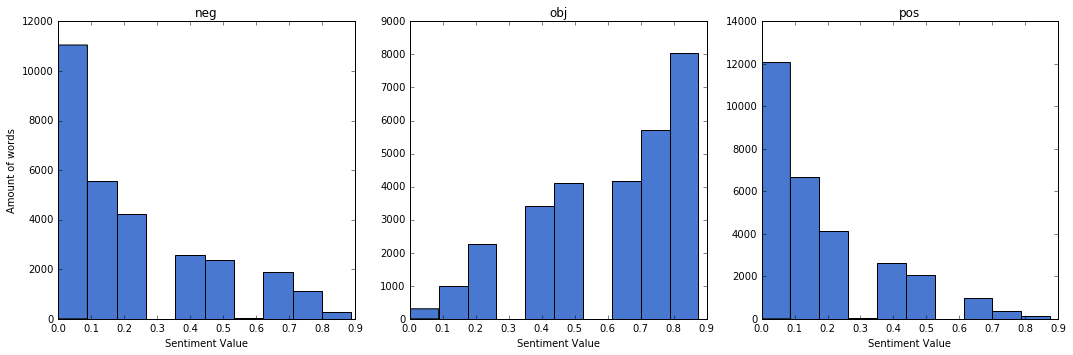

In [267]:
import pandas as pd
all_sent_df = pd.DataFrame(all_sent)
f, ax = plt.subplots(figsize=(15, 5))
axis = all_sent_df[((all_sent_df>0) & (all_sent_df<1)).any(axis=1)].hist(grid=False, layout=(1,3),ax=ax)
axs = axis[0]
axs[0].set_ylabel('Amount of words')

for a in axs:
    a.set_xlabel('Sentiment Value')
    
f.tight_layout()

#alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none', grid=False)

For all the tweets (that are already tokenized) find the pos, neg and objectivity value of the words. As there can be more than one synset for a word/pos, the most common will be used. 

The fatures created will follow the one [here](http://infomesr.org/attachments/123.pdf)

Constructing a Machine Learning model with the features created

In [35]:
# 
params = dict(
 return_tokens=False, return_sum=True, 
 return_avg=True, return_thresh=True, thresh=.75,
 return_decision=True, use_median_word=False)

ret_swn = run_lex_test(r.swn, **params)
pipe.pprint_results(ret_swn)

[{'SWN_obj_tot': 5.0, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.0, 'SWN_DECISION': 0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.0, 'SWN_neg_avg': 0.0, 'SWN_pos_avg': 0.0}, {'SWN_obj_tot': 2.75, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.125, 'SWN_DECISION': 0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.125, 'SWN_neg_avg': 0.041666666666666664, 'SWN_pos_avg': 0.041666666666666664}, {'SWN_obj_tot': 5.25, 'SWN_pos_avg_tre': 0.125, 'SWN_pos_tot': 0.375, 'SWN_DECISION': -1, 'SWN_neg_avg_tre': 0.4583333333333333, 'SWN_neg_tot': 1.375, 'SWN_neg_avg': 0.19642857142857142, 'SWN_pos_avg': 0.05357142857142857}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 8) (8171, 935)
test data, lex and final shape:  (1405, 927) (1405, 8) (1405, 935)


In [36]:
ret_swn = run_lex_test(r.swn, negate=True, **dict(return_tokens=True))
pipe.pprint_results(ret_swn)

[{'SWN_DECISION': 0, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.0, u'SWN_POS_hit': 0.0, u'SWN_NEG_house': 0.0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.0, 'SWN_neg_avg': 0.0, u'SWN_POS_chapel': 0.0, u'SWN_OBJ_chapel': 1.0, u'SWN_POS_hill': 0.0, 'SWN_obj_tot': 5.0, u'SWN_OBJ_house': 1.0, u'SWN_NEG_gas': 0.0, u'SWN_NEG_hill': 0.0, u'SWN_OBJ_hit': 1.0, u'SWN_POS_gas': 0.0, u'SWN_POS_house': 0.0, 'SWN_pos_avg': 0.0, u'SWN_NEG_chapel': 0.0, u'SWN_OBJ_hill': 1.0, u'SWN_NEG_hit': 0.0, u'SWN_OBJ_gas': 1.0}, {u'SWN_NEG_deal': 0.0, 'SWN_DECISION': 0, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.125, u'SWN_POS_deal': 0.0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.125, 'SWN_neg_avg': 0.041666666666666664, 'SWN_obj_tot': 2.75, u'SWN_NEG_watch': 0.0, u'SWN_OBJ_still': 0.875, u'SWN_POS_still': 0.0, u'SWN_OBJ_deal': 1.0, u'SWN_NEG_still': 0.125, u'SWN_POS_watch': 0.125, u'SWN_OBJ_watch': 0.875, 'SWN_pos_avg': 0.041666666666666664}, {u'SWN_NEG_just': 0.0, 'SWN_DECISION': -1, 'SWN_pos_avg_tre': 0.125, 'SWN_pos_tot': 0

This lowered all the algorithm values, not a good approach

In [114]:
# feature selection
compare_percentiles(r.swn, **dict(return_tokens=True))

Final shape (8171, 881) (1405, 881)
train data, lex and final shape:  (8171, 927) (8171, 881) (8171, 1808)
test data, lex and final shape:  (1405, 927) (1405, 881) (1405, 1808)
Final shape (8171, 1763) (1405, 1763)
train data, lex and final shape:  (8171, 927) (8171, 1763) (8171, 2690)
test data, lex and final shape:  (1405, 927) (1405, 1763) (1405, 2690)
Final shape (8171, 2644) (1405, 2644)
train data, lex and final shape:  (8171, 927) (8171, 2644) (8171, 3571)
test data, lex and final shape:  (1405, 927) (1405, 2644) (1405, 3571)
Final shape (8171, 5289) (1405, 5289)
train data, lex and final shape:  (8171, 927) (8171, 5289) (8171, 6216)
test data, lex and final shape:  (1405, 927) (1405, 5289) (1405, 6216)
Final shape (8171, 17633) (1405, 17633)
train data, lex and final shape:  (8171, 927) (8171, 17633) (8171, 18560)
test data, lex and final shape:  (1405, 927) (1405, 17633) (1405, 18560)


The 10 percentile is the most performatic setting. How does it compare to the base

In [52]:
ret_swn = run_lex_test(r.swn, verbose=False, select=True, percent=10, **dict(return_tokens=True))
pipe.pprint_results(ret_swn-base_scores)

Final shape (8171, 1763) (1405, 1763)
train data, lex and final shape:  (8171, 927) (8171, 1763) (8171, 2690)
test data, lex and final shape:  (1405, 927) (1405, 1763) (1405, 2690)


Checking the hypothesis on (Hamouda and Rohaim, 2011) that the use of the median of the values aof all synsets could cause a difference in the pipeline

In [309]:
print sentiwordnet.senti_synsets('pure', 'a')
print u.penn_to_wn('JJ')
print r.swn.get_median_synset_values(['pure', 'JJ'])
print r.swn.get_synset_values(['pure', 'JJ'])

[SentiSynset('pure.a.01'), SentiSynset('arrant.s.01'), SentiSynset('saturated.a.03'), SentiSynset('pure.s.04'), SentiSynset('pure.s.05'), SentiSynset('pure.a.06'), SentiSynset('pure.s.07')]
a
[0.32142857142857145, 0.16071428571428573, 0.5178571428571429]
[0.375, 0.125, 0.5]


In [313]:
# only the decision
params = dict(
return_tokens=False, return_sum=False, 
 return_avg=False, return_thresh=False, thresh=.75,
 return_decision=True, use_median_word=True)

# try returning a token of objective, negative and positive score for each token
ret_swn = run_lex_test(r.swn, negate=True, **params)
pipe.pprint_results(ret_swn)

libs/resources.py:1705: RuntimeWarning: Mean of empty slice.
  ret = np.array([(s.pos_score(), s.neg_score(), s.obj_score())  for s in synsets]).mean(axis=0).tolist()


[{'SWN_DECISION': -1}, {'SWN_DECISION': -1}, {'SWN_DECISION': -1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


In [314]:
# Returning just the thresholded values and avg words
params = dict(
 return_tokens=False, return_sum=False, 
 return_avg=False, return_thresh=True, thresh=.75,
 return_decision=False, use_median_word=True)

ret_swn = run_lex_test(r.swn, negate=True, **params)
pipe.pprint_results(ret_swn)

[{'SWN_neg_avg_tre': 0, 'SWN_pos_avg_tre': 0}, {'SWN_neg_avg_tre': 0.28125, 'SWN_pos_avg_tre': 0.03125}, {'SWN_neg_avg_tre': 0.4583333333333333, 'SWN_pos_avg_tre': 0.125}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


In [315]:
# Returning just the thresholded values and the first word of the synset
params = dict(
return_tokens=False, return_sum=False, 
 return_avg=False, return_thresh=True, thresh=.75,
 return_decision=False, use_median_word=False)

ret_swn = run_lex_test(r.swn, negate=True, **params)
pipe.pprint_results(ret_swn)

[{'SWN_neg_avg_tre': 0, 'SWN_pos_avg_tre': 0}, {'SWN_neg_avg_tre': 0, 'SWN_pos_avg_tre': 0}, {'SWN_neg_avg_tre': 0.4583333333333333, 'SWN_pos_avg_tre': 0.125}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


In [316]:
# returning only the regular stats, no threshold
params = dict(
return_tokens=False, return_sum=True, 
return_avg=True, return_thresh=False, thresh=1,
return_decision=True, use_median_word=True)

ret_swn = run_lex_test(r.swn, negate=True, **params)
pipe.pprint_results(ret_swn)

[{'SWN_DECISION': -1, 'SWN_pos_tot': 0.016666666666666666, 'SWN_pos_avg': 0.0023809523809523807, 'SWN_obj_tot': 6.890196078431373, 'SWN_neg_tot': 0.09313725490196079, 'SWN_neg_avg': 0.01330532212885154}, {'SWN_DECISION': -1, 'SWN_pos_tot': 0.18509615384615385, 'SWN_pos_avg': 0.046274038461538464, 'SWN_obj_tot': 3.496565934065934, 'SWN_neg_tot': 0.31833791208791207, 'SWN_neg_avg': 0.07958447802197802}, {'SWN_DECISION': -1, 'SWN_pos_tot': 0.5148809523809523, 'SWN_pos_avg': 0.0572089947089947, 'SWN_obj_tot': 7.050595238095238, 'SWN_neg_tot': 1.4107142857142856, 'SWN_neg_avg': 0.15674603174603174}]
train data, lex and final shape:  (8171, 927) (8171, 6) (8171, 933)
test data, lex and final shape:  (1405, 927) (1405, 6) (1405, 933)


In [317]:
# a pipeline where all the stats are enabled
params = dict(
return_tokens=False, return_sum=False, 
 return_avg=False, return_thresh=True, thresh=.50,
 return_decision=False, use_median_word=True)

ret_swn = run_lex_test(r.swn, negate=True,**params)
pipe.pprint_results(ret_swn)

[{'SWN_neg_avg_tre': 0, 'SWN_pos_avg_tre': 0}, {'SWN_neg_avg_tre': 0, 'SWN_pos_avg_tre': 0}, {'SWN_neg_avg_tre': 0.6875, 'SWN_pos_avg_tre': 0.0}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


In [318]:
# a pipeline where all the stats are enabled
params = dict(
return_tokens=False, return_sum=True, 
 return_avg=True, return_thresh=True, thresh=.25,
 return_decision=True, use_median_word=False)

ret_swn = run_lex_test(r.swn, negate=True,**params)
pipe.pprint_results(ret_swn)

[{'SWN_obj_tot': 5.0, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.0, 'SWN_DECISION': 0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.0, 'SWN_neg_avg': 0.0, 'SWN_pos_avg': 0.0}, {'SWN_obj_tot': 2.75, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.125, 'SWN_DECISION': 0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.125, 'SWN_neg_avg': 0.041666666666666664, 'SWN_pos_avg': 0.041666666666666664}, {'SWN_obj_tot': 3.25, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.375, 'SWN_DECISION': -1, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 1.375, 'SWN_neg_avg': 0.275, 'SWN_pos_avg': 0.075}]
train data, lex and final shape:  (8171, 927) (8171, 8) (8171, 935)
test data, lex and final shape:  (1405, 927) (1405, 8) (1405, 935)


### Best Model SWN

In [37]:
# a pipeline where all the stats are enabled
params = dict(
 return_tokens=False, return_sum=True, 
 return_avg=True, return_thresh=True, thresh=.75,
 return_decision=True, use_median_word=False)

ret_swn = run_lex_test(r.swn, negate=True,**params)
pipe.pprint_results(ret_swn)

[{'SWN_obj_tot': 5.0, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.0, 'SWN_DECISION': 0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.0, 'SWN_neg_avg': 0.0, 'SWN_pos_avg': 0.0}, {'SWN_obj_tot': 2.75, 'SWN_pos_avg_tre': 0, 'SWN_pos_tot': 0.125, 'SWN_DECISION': 0, 'SWN_neg_avg_tre': 0, 'SWN_neg_tot': 0.125, 'SWN_neg_avg': 0.041666666666666664, 'SWN_pos_avg': 0.041666666666666664}, {'SWN_obj_tot': 3.25, 'SWN_pos_avg_tre': 0.125, 'SWN_pos_tot': 0.375, 'SWN_DECISION': -1, 'SWN_neg_avg_tre': 0.4583333333333333, 'SWN_neg_tot': 1.375, 'SWN_neg_avg': 0.275, 'SWN_pos_avg': 0.075}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 8) (8171, 935)
test data, lex and final shape:  (1405, 927) (1405, 8) (1405, 935)


In general, using a threshold helped the algorithm more than using all the lexicons or all the stats

In [324]:
a = scy.stats.ttest_ind_from_stats(base_scores['dev score'], base_scores['dev std'], 10,
                               ret_swn['dev score'], ret_swn['dev std'], 10)
a.pvalue < 0.05

array([False, False, False], dtype=bool)

In [322]:
a.pvalue

array([ 0.06886022,  0.23531174,  0.89026943])

### Conclusion
The SWN added very little to the prediction

### MSOL
Msol is a lexicon created using a thesaurus as a base (Macquarie). The construction was done finding seeds of words that represented polarities and then using them to discover set of words with same polarities

In [38]:
r.msol.df.sample(10)

,MSOL
harass,-1
half-tone,1
long-haired,-1
pigface,-1
shipping_lane,-1
percussionist,1
buzz_about,1
flash_blindness,-1
john_bromwich,1
determinate,1


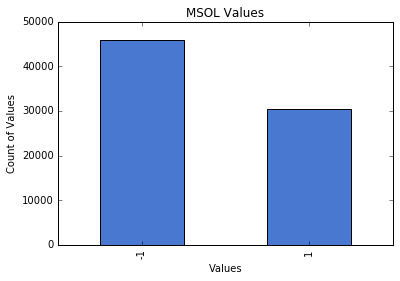

In [39]:
print_lex_hist(r.msol.df['MSOL'], 'MSOL Values')

As it can be seen, this lexicon has composed words. So here we need to deal with bigrams and trigrams and they must be separated by _

In [40]:
msol_features = {
    'return_tokens':True,
    'return_avg':False,
    'return_sum':False,
    'return_min':False,
    'return_max':False,
    'return_pol_amt':False,
    'final_pol':False
}

In [47]:
ret_msol = run_lex_test(r.msol, verbose=True, use_best_params=False, **msol_features)
pipe.pprint_results(ret_msol)

[{'MSOL_sum': 4, 'MSOL_max': 1, 'MSOL_posamt': 6, u'MSOL_house': -1, u'MSOL_gas': 1, 'MSOL_min': -1, u'MSOL_hit': -1, 'MSOL_avg': 0.5, u'MSOL_by': 1, u'MSOL_chapel': 1, u'MSOL_hill': 1, u'MSOL_my': 1, 'MSOL_negamt': 2, u'MSOL_going': 1, 'MSOL_fpol': 1}, {'MSOL_sum': -1, 'MSOL_max': 1, u'MSOL_watch': 1, u'MSOL_deal': -1, 'MSOL_min': -1, 'MSOL_negamt': 3, 'MSOL_avg': -0.20000000000000001, u'MSOL_shit': -1, u'MSOL_still': -1, u'MSOL_johnny': 1, 'MSOL_posamt': 2, 'MSOL_fpol': -1}, {'MSOL_sum': -1, 'MSOL_max': 1, u'MSOL_just': 1, 'MSOL_min': -1, 'MSOL_negamt': 3, 'MSOL_avg': -0.20000000000000001, u'MSOL_hate': -1, u'MSOL_wait': -1, 'MSOL_posamt': 2, u'MSOL_nick': -1, 'MSOL_fpol': -1, u'MSOL_fan': 1}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 6379) (8171, 7306)
test data, lex and final shape:  (1405, 927) (1405, 6379) (1405, 7306)


In [42]:
ret_msol = run_lex_test(r.msol, negate=True, **msol_features)
pipe.pprint_results(ret_msol)

[{u'MSOL_house': -1, u'MSOL_gas': 1, u'MSOL_hit': -1, u'MSOL_by': 1, u'MSOL_chapel': 1, u'MSOL_hill': 1, u'MSOL_my': 1, u'MSOL_going': 1}, {u'MSOL_deal': -1, u'MSOL_still': -1, u'MSOL_watch': 1, u'MSOL_johnny': 1, u'MSOL_shit': -1}, {u'MSOL_NEG_wait_NEG_for': -1, u'MSOL_NEG_that': -1, u'MSOL_NEG_a': 1, u'MSOL_just': 1, u'MSOL_hate': -1, u'MSOL_NEG_wait': 1, u'MSOL_NEG_fan': -1, u'MSOL_nick': -1, u'MSOL_NEG_for': -1}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8170.0, 8171, 1405.0, 1405)
Coverage train: 99.99%, test: 99.99%
train data, lex and final shape:  (8171, 927) (8171, 7651) (8171, 8578)
test data, lex and final shape:  (1405, 927) (1405, 7651) (1405, 8578)


In [169]:
a = scy.stats.ttest_ind_from_stats(base_scores['dev score'], base_scores['dev std'], 10,
                               ret_msol['dev score'], ret_msol['dev std'], 10)
a.pvalue < 0.05

array([False, False, False], dtype=bool)

Considering all the tags generated and then selecting the K% best

In [190]:
msol_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.msol, negate=True, **msol_features)

Final shape (8171, 382) (1405, 382)
train data, lex and final shape:  (8171, 927) (8171, 382) (8171, 1309)
test data, lex and final shape:  (1405, 927) (1405, 382) (1405, 1309)
Final shape (8171, 765) (1405, 765)
train data, lex and final shape:  (8171, 927) (8171, 765) (8171, 1692)
test data, lex and final shape:  (1405, 927) (1405, 765) (1405, 1692)
Final shape (8171, 1148) (1405, 1148)
train data, lex and final shape:  (8171, 927) (8171, 1148) (8171, 2075)
test data, lex and final shape:  (1405, 927) (1405, 1148) (1405, 2075)
Final shape (8171, 2297) (1405, 2297)
train data, lex and final shape:  (8171, 927) (8171, 2297) (8171, 3224)
test data, lex and final shape:  (1405, 927) (1405, 2297) (1405, 3224)
Final shape (8171, 7657) (1405, 7657)
train data, lex and final shape:  (8171, 927) (8171, 7657) (8171, 8584)
test data, lex and final shape:  (1405, 927) (1405, 7657) (1405, 8584)


In [331]:
msol_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.msol, negate=False, **msol_features)

Final shape (8171, 319) (1405, 319)
train data, lex and final shape:  (8171, 927) (8171, 319) (8171, 1246)
test data, lex and final shape:  (1405, 927) (1405, 319) (1405, 1246)
Final shape (8171, 637) (1405, 637)
train data, lex and final shape:  (8171, 927) (8171, 637) (8171, 1564)
test data, lex and final shape:  (1405, 927) (1405, 637) (1405, 1564)
Final shape (8171, 956) (1405, 956)
train data, lex and final shape:  (8171, 927) (8171, 956) (8171, 1883)
test data, lex and final shape:  (1405, 927) (1405, 956) (1405, 1883)
Final shape (8171, 1913) (1405, 1913)
train data, lex and final shape:  (8171, 927) (8171, 1913) (8171, 2840)
test data, lex and final shape:  (1405, 927) (1405, 1913) (1405, 2840)
Final shape (8171, 6379) (1405, 6379)
train data, lex and final shape:  (8171, 927) (8171, 6379) (8171, 7306)
test data, lex and final shape:  (1405, 927) (1405, 6379) (1405, 7306)


### Best Model MSOL

In [46]:
msol_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_msol = run_lex_test(r.msol, negate=False, select=True, percent=5,**msol_features)
pipe.pprint_results(ret_msol)

[{'MSOL_sum': 4, 'MSOL_max': 1, 'MSOL_posamt': 6, u'MSOL_house': -1, u'MSOL_gas': 1, 'MSOL_min': -1, u'MSOL_hit': -1, 'MSOL_avg': 0.5, u'MSOL_by': 1, u'MSOL_chapel': 1, u'MSOL_hill': 1, u'MSOL_my': 1, 'MSOL_negamt': 2, u'MSOL_going': 1, 'MSOL_fpol': 1}, {'MSOL_sum': -1, 'MSOL_max': 1, u'MSOL_watch': 1, u'MSOL_deal': -1, 'MSOL_min': -1, 'MSOL_negamt': 3, 'MSOL_avg': -0.20000000000000001, u'MSOL_shit': -1, u'MSOL_still': -1, u'MSOL_johnny': 1, 'MSOL_posamt': 2, 'MSOL_fpol': -1}, {'MSOL_sum': -1, 'MSOL_max': 1, u'MSOL_just': 1, 'MSOL_min': -1, 'MSOL_negamt': 3, 'MSOL_avg': -0.20000000000000001, u'MSOL_hate': -1, u'MSOL_wait': -1, 'MSOL_posamt': 2, u'MSOL_nick': -1, 'MSOL_fpol': -1, u'MSOL_fan': 1}]
Final shape (8171, 319) (1405, 319)
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8170.0, 8171, 1405.0, 1405)
Coverage train: 99.99%, test: 99.99%
train data, lex and final shape:  (8171, 927) (8171, 319) (8171, 1246)
test data, lex and final shape:  (1405, 927) (1405, 319) (1405

In [68]:
a = scy.stats.ttest_ind_from_stats(base_scores['dev score'], base_scores['dev std'], 10,
                               ret_msol['dev score'], ret_msol['dev std'], 10)
a.pvalue < 0.05

array([False, False, False], dtype=bool)

### Conclusion: 
the dictionary did not gave a significant improvement

### NRC Hashtag

The National Resource Canada created a lexicon from a series os polarity known hashtags. Basically they have used these hashtags to collect tweets and then using PMI they checked with word appeared more with the hashtags, giving them scores.

In [48]:
r.nhash.df.sample(10)

,NRCHASH
i downloaded,0.344
bright purple,0.478
plaids,0.478
i---will help,-4.999
we---it to,5.000
why---food,-1.408
@avabandofficial,0.478
was waiting,-0.175
starting---when,-4.999
blaring out,0.883


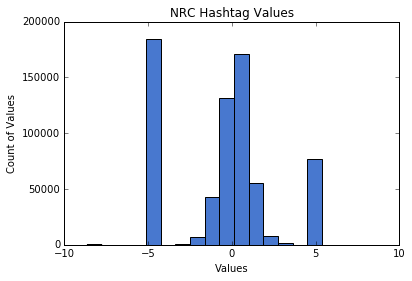

In [192]:
a = r.nhash.df.hist(bins=20, grid=False)[0][0]
a.set_title('NRC Hashtag Values')
a.set_xlabel('Values')
_ = a.set_ylabel('Count of Values')

As many of the lexicons so far, we have a very group of really negative tokens. Also expected is that most of the tokens are close to the 0, where their polarity is not very clear.

This lexicon work with non contiguous words. That means that giving a set of words, some of them were removed. I.e. **be---life**. This mean be *my* life, be *your* life, etc

In [71]:
print('Original number of tokens {}'.format(len(train_tokens[0])))
ct = p.non_contiguous(train_tokens[0])
print('Original number of tokens {}'.format(len(train_tokens[0])))
print('Contiguous number now {}'.format(len(ct)))
ct[0]

Original number of tokens 14
Original number of tokens 14
Contiguous number now 80


u'---by my house'

The number of possible tokens jumped from 14 to 80.

### Best Model NHash

In [75]:
nhash_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True,
    'bigrams': False,
    'trigrams': False,
    'non_contiguous': True
}
ret_nhash = run_lex_test(r.nhash, verbose=True, **nhash_features)
pipe.pprint_results(ret_nhash)

[{'NRCHASH_negamt': 3, 'NRCHASH_avg': 0.19545454545454544, 'NRCHASH_fpol': 1, 'NRCHASH_max': 0.78000000000000003, 'NRCHASH_posamt': 8, 'NRCHASH_sum': 2.1499999999999999, 'NRCHASH_min': -0.33500000000000002}, {'NRCHASH_negamt': 7, 'NRCHASH_avg': -0.42350000000000004, 'NRCHASH_fpol': -1, 'NRCHASH_max': 0.89700000000000002, 'NRCHASH_posamt': 7, 'NRCHASH_sum': -5.9290000000000003, 'NRCHASH_min': -4.9989999999999997}, {'NRCHASH_negamt': 8, 'NRCHASH_avg': -0.16707142857142857, 'NRCHASH_fpol': -1, 'NRCHASH_max': 1.528, 'NRCHASH_posamt': 6, 'NRCHASH_sum': -2.339, 'NRCHASH_min': -1.8879999999999999}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [50]:
ret_nhash = run_lex_test(r.nhash, verbose=True, negate=True, **nhash_features)
pipe.pprint_results(ret_nhash)

[{'NRCHASH_negamt': 3, 'NRCHASH_avg': 0.19545454545454544, 'NRCHASH_fpol': 1, 'NRCHASH_max': 0.78000000000000003, 'NRCHASH_posamt': 8, 'NRCHASH_sum': 2.1499999999999999, 'NRCHASH_min': -0.33500000000000002}, {'NRCHASH_negamt': 7, 'NRCHASH_avg': -0.42350000000000004, 'NRCHASH_fpol': -1, 'NRCHASH_max': 0.89700000000000002, 'NRCHASH_posamt': 7, 'NRCHASH_sum': -5.9290000000000003, 'NRCHASH_min': -4.9989999999999997}, {'NRCHASH_negamt': 10, 'NRCHASH_avg': -0.15605882352941178, 'NRCHASH_fpol': -1, 'NRCHASH_max': 1.528, 'NRCHASH_posamt': 7, 'NRCHASH_sum': -2.653, 'NRCHASH_min': -1.8879999999999999}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [74]:
a = scy.stats.ttest_ind_from_stats(base_scores['dev score'], base_scores['dev std'], 10,
                               ret_nhash['dev score'], ret_nhash['dev std'], 10)
a.pvalue < 0.05

array([ True, False,  True], dtype=bool)

In [196]:
nhash_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_nhash = run_lex_test(r.nhash, verbose=False, **nhash_features)

train data, lex and final shape:  (8171, 927) (8171, 44196) (8171, 45123)
test data, lex and final shape:  (1405, 927) (1405, 44196) (1405, 45123)


In [76]:
pipe.pprint_results(ret_nhash)

In [77]:
nhash_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.nhash, percentiles = [5,10,15,30], **nhash_features)

Final shape (8171, 2209) (1405, 2209)
train data, lex and final shape:  (8171, 927) (8171, 2209) (8171, 3136)
test data, lex and final shape:  (1405, 927) (1405, 2209) (1405, 3136)
Final shape (8171, 4419) (1405, 4419)
train data, lex and final shape:  (8171, 927) (8171, 4419) (8171, 5346)
test data, lex and final shape:  (1405, 927) (1405, 4419) (1405, 5346)
Final shape (8171, 6629) (1405, 6629)
train data, lex and final shape:  (8171, 927) (8171, 6629) (8171, 7556)
test data, lex and final shape:  (1405, 927) (1405, 6629) (1405, 7556)
Final shape (8171, 13258) (1405, 13258)
train data, lex and final shape:  (8171, 927) (8171, 13258) (8171, 14185)
test data, lex and final shape:  (1405, 927) (1405, 13258) (1405, 14185)


In [78]:
nhash_features = {
    'return_tokens':True,
}
compare_percentiles(r.nhash, percentiles = [5,10,15,30], **nhash_features)

Final shape (8171, 2209) (1405, 2209)
train data, lex and final shape:  (8171, 927) (8171, 2209) (8171, 3136)
test data, lex and final shape:  (1405, 927) (1405, 2209) (1405, 3136)
Final shape (8171, 4419) (1405, 4419)
train data, lex and final shape:  (8171, 927) (8171, 4419) (8171, 5346)
test data, lex and final shape:  (1405, 927) (1405, 4419) (1405, 5346)
Final shape (8171, 6628) (1405, 6628)
train data, lex and final shape:  (8171, 927) (8171, 6628) (8171, 7555)
test data, lex and final shape:  (1405, 927) (1405, 6628) (1405, 7555)
Final shape (8171, 13257) (1405, 13257)
train data, lex and final shape:  (8171, 927) (8171, 13257) (8171, 14184)
test data, lex and final shape:  (1405, 927) (1405, 13257) (1405, 14184)


In [79]:
pipe.pprint_results(base_scores)

In [208]:
nhash_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in nhash_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_nhash = run_lex_test(r.nhash, verbose=True, join_char='_', **tmp)
    display(pipe.pprint_results(ret_nhash))

Testing key return_max
[{'NRCHASH_max': 0.78000000000000003}, {'NRCHASH_max': 0.89700000000000002}, {'NRCHASH_max': 1.528}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_sum
[{'NRCHASH_sum': 2.1499999999999999}, {'NRCHASH_sum': -5.9290000000000003}, {'NRCHASH_sum': -2.339}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_avg
[{'NRCHASH_avg': 0.19545454545454544}, {'NRCHASH_avg': -0.42350000000000004}, {'NRCHASH_avg': -0.16707142857142857}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_tokens
[{u'NRCHASH_chapel': 0.78, u'NRCHASH_sat': 0.213, u'NRCHASH_.': -0.06, u'NRCHASH_my': 0.304, u'NRCHASH_hill': 0.619, u'NRCHASH_going': 0.056, u'NRCHASH_my---hit': 0.141, u'NRCHASH_hit': -0.335, u'NRCHASH_house': 0.287, u'NRCHASH_gas': -0.216, u'NRCHASH_by': 0.361}, {u'NRCHASH_.': -0.06, u'NRCHASH_is---shit': -4.999, u'NRCHASH_,': 0.271, u'NRCHASH_johnny': 0.897, u'NRCHASH_saturday': 0.57, u'NRCHASH_watch': 0.138, u'NRCHASH_him': -0.452, u'NRCHASH_is': 0.005, u'NRCHASH_theo': 0.127, u'NRCHASH_deal': -0.445, u'NRCHASH_shit': -0.797, u'NRCHASH_still': -0.408, u'NRCHASH_rafa': -1.025, u'NRCHASH_walcott': 0.249}, {u'NRCHASH_.': -0.06, u'NRCHASH_i---hate': -1.888, u'NRCHASH_,': 0.271, u'NRCHASH_february': 0.366, u'NRCHASH_i': -0.172, u'NRCHASH_fan': -0.307, u'NRCHASH_gsp': -0.214, u'NRCHASH_diaz': 1.528, u'NRCHASH_its': -0.183, u'NRCHASH_hate': -1.681, u'NRCHASH_nick': 0.195, u'NRCHASH_just': 0.059, u'NRCHASH_not': -0.628, u'NRCHASH_wait': 0.375}]
train data, lex an

Testing key return_pol_amt
[{'NRCHASH_negamt': 3, 'NRCHASH_posamt': 8}, {'NRCHASH_negamt': 7, 'NRCHASH_posamt': 7}, {'NRCHASH_negamt': 8, 'NRCHASH_posamt': 6}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


Testing key final_pol
[{'NRCHASH_fpol': 1}, {'NRCHASH_fpol': -1}, {'NRCHASH_fpol': -1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_min
[{'NRCHASH_min': -0.33500000000000002}, {'NRCHASH_min': -4.9989999999999997}, {'NRCHASH_min': -1.8879999999999999}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


In [216]:
nhash_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':False,
    'return_pol_amt':True,
    'final_pol':True
}

ret_nhash = run_lex_test(r.nhash, verbose=False, join_char='_', **nhash_features)
pipe.pprint_results(ret_nhash)

train data, lex and final shape:  (8171, 927) (8171, 6) (8171, 933)
test data, lex and final shape:  (1405, 927) (1405, 6) (1405, 933)


#### Conclusion: 
the dictionary offered some improvement to the pipeline

### Sentiment 140
This lexicon took the same approach of the NRC Hashtag, but the corpus used was bigger, totalling 1.6 Million tweets.

In [225]:
r.s140.df.SENT140.min()

-5.6059999999999999

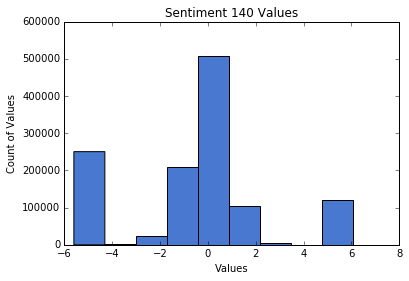

In [227]:
a = r.s140.df.SENT140.hist(bins=10, grid=False)
a.set_title('Sentiment 140 Values')
a.set_xlabel('Values')
_ = a.set_ylabel('Count of Values')

In [234]:
r.s140.df.sample(15)

,SENT140
photo :---looks,5.000
@adityarao310,5.000
am off---to bed,5.000
in coming,0.231
weiner,0.560
was insanely,1.435
joke has,-0.643
just---the cd,-4.999
like amsterdam,0.742
"congrats """,1.435


This distribution seems more or less similar with the one found in the NRC Hash, but the values are between -5 and 5. This seems to show that the previous lexicon had some problem.

In [69]:
s140_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_s140 = run_lex_test(r.s140, verbose=True, **s140_features)
pipe.pprint_results(ret_s140)

[{'SENT140_min': -1.4399999999999999, 'SENT140_fpol': -1, 'SENT140_sum': -3.8569999999999993, 'SENT140_posamt': 5, 'SENT140_avg': -0.20299999999999996, 'SENT140_negamt': 14, 'SENT140_max': 0.67100000000000004}, {'SENT140_min': -4.9989999999999997, 'SENT140_fpol': -1, 'SENT140_sum': -8.9890000000000008, 'SENT140_posamt': 8, 'SENT140_avg': -0.44945000000000002, 'SENT140_negamt': 12, 'SENT140_max': 1.0109999999999999}, {'SENT140_min': -2.6699999999999999, 'SENT140_fpol': 1, 'SENT140_sum': 1.2480000000000009, 'SENT140_posamt': 10, 'SENT140_avg': 0.043034482758620721, 'SENT140_negamt': 19, 'SENT140_max': 5.0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


### Best Model S140

In [76]:
# testing the removal of bigrams and trigrams.
s140_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True,
    'bigrams': True,
    'non_contiguous':False,
    'trigrams':False
}
ret_s140 = run_lex_test(r.s140, verbose=True, **s140_features)
pipe.pprint_results(ret_s140)

[{'SENT140_min': -0.97199999999999998, 'SENT140_fpol': -1, 'SENT140_sum': -2.4169999999999994, 'SENT140_posamt': 5, 'SENT140_avg': -0.13427777777777775, 'SENT140_negamt': 13, 'SENT140_max': 0.67100000000000004}, {'SENT140_min': -1.4570000000000001, 'SENT140_fpol': -1, 'SENT140_sum': -2.7300000000000004, 'SENT140_posamt': 8, 'SENT140_avg': -0.1516666666666667, 'SENT140_negamt': 10, 'SENT140_max': 1.0109999999999999}, {'SENT140_min': -1.851, 'SENT140_fpol': -1, 'SENT140_sum': -5.399, 'SENT140_posamt': 7, 'SENT140_avg': -0.23473913043478262, 'SENT140_negamt': 16, 'SENT140_max': 1.355}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [77]:
# testing the removal of bigrams and trigrams, adding non-contiguous
s140_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True,
    'bigrams': True,
    'non_contiguous':True,
    'trigrams':False
}
ret_s140 = run_lex_test(r.s140, verbose=True, **s140_features)
pipe.pprint_results(ret_s140)

[{'SENT140_min': -1.4399999999999999, 'SENT140_fpol': -1, 'SENT140_sum': -3.8569999999999993, 'SENT140_posamt': 5, 'SENT140_avg': -0.20299999999999996, 'SENT140_negamt': 14, 'SENT140_max': 0.67100000000000004}, {'SENT140_min': -4.9989999999999997, 'SENT140_fpol': -1, 'SENT140_sum': -8.9890000000000008, 'SENT140_posamt': 8, 'SENT140_avg': -0.44945000000000002, 'SENT140_negamt': 12, 'SENT140_max': 1.0109999999999999}, {'SENT140_min': -2.6699999999999999, 'SENT140_fpol': 1, 'SENT140_sum': 1.2480000000000009, 'SENT140_posamt': 10, 'SENT140_avg': 0.043034482758620721, 'SENT140_negamt': 19, 'SENT140_max': 5.0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [237]:
ret_s140 = run_lex_test(r.s140, verbose=True, negate=True, **s140_features)
pipe.pprint_results(ret_s140)

[{'SENT140_min': -1.4399999999999999, 'SENT140_fpol': -1, 'SENT140_sum': -3.8569999999999993, 'SENT140_posamt': 5, 'SENT140_avg': -0.20299999999999996, 'SENT140_negamt': 14, 'SENT140_max': 0.67100000000000004}, {'SENT140_min': -4.9989999999999997, 'SENT140_fpol': -1, 'SENT140_sum': -8.9890000000000008, 'SENT140_posamt': 8, 'SENT140_avg': -0.44945000000000002, 'SENT140_negamt': 12, 'SENT140_max': 1.0109999999999999}, {'SENT140_min': -2.6699999999999999, 'SENT140_fpol': -1, 'SENT140_sum': -3.5160000000000009, 'SENT140_posamt': 11, 'SENT140_avg': -0.10045714285714288, 'SENT140_negamt': 24, 'SENT140_max': 5.0}]
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [84]:
s140_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.s140, percentiles=[5,10,15,30], **s140_features)

Final shape (8171, 2883) (1405, 2883)
train data, lex and final shape:  (8171, 927) (8171, 2883) (8171, 3810)
test data, lex and final shape:  (1405, 927) (1405, 2883) (1405, 3810)
Final shape (8171, 5766) (1405, 5766)
train data, lex and final shape:  (8171, 927) (8171, 5766) (8171, 6693)
test data, lex and final shape:  (1405, 927) (1405, 5766) (1405, 6693)
Final shape (8171, 8649) (1405, 8649)
train data, lex and final shape:  (8171, 927) (8171, 8649) (8171, 9576)
test data, lex and final shape:  (1405, 927) (1405, 8649) (1405, 9576)
Final shape (8171, 17298) (1405, 17298)
train data, lex and final shape:  (8171, 927) (8171, 17298) (8171, 18225)
test data, lex and final shape:  (1405, 927) (1405, 17298) (1405, 18225)


In [85]:
s140_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.s140, percentiles=[100], **s140_features)

Final shape (8171, 57660) (1405, 57660)
train data, lex and final shape:  (8171, 927) (8171, 57660) (8171, 58587)
test data, lex and final shape:  (1405, 927) (1405, 57660) (1405, 58587)


In [247]:
s140_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in s140_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_nhash = run_lex_test(r.s140, verbose=True, join_char='_', **tmp)
    display(pipe.pprint_results(ret_nhash))

Testing key return_max
[{'SENT140_max': 0.67100000000000004}, {'SENT140_max': 0.26000000000000001}, {'SENT140_max': 5.0}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_sum
[{'SENT140_sum': -2.7879999999999994}, {'SENT140_sum': -8.9120000000000008}, {'SENT140_sum': 3.2629999999999995}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_min
[{'SENT140_min': -1.4399999999999999}, {'SENT140_min': -4.9989999999999997}, {'SENT140_min': -2.6699999999999999}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_avg
[{'SENT140_avg': -0.21446153846153843}, {'SENT140_avg': -0.63657142857142868}, {'SENT140_avg': 0.16314999999999996}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_pol_amt
[{'SENT140_posamt': 4, 'SENT140_negamt': 9}, {'SENT140_posamt': 5, 'SENT140_negamt': 9}, {'SENT140_posamt': 8, 'SENT140_negamt': 12}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


Testing key final_pol
[{'SENT140_fpol': -1}, {'SENT140_fpol': -1}, {'SENT140_fpol': 1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


**Conclusion:** The lexicon also did not added too much.

### Ts-Lex
The dictionary was created from a Neural Network and then used association to find the words polarities.

In [249]:
print(r.tslex.df.shape)
r.tslex.df.sample(10)

(347447, 1)


,TSLEX
jett,0.829647
a bit with,0.770018
! huhu :(,-0.997504
#thatslife,-0.709762
:d <3 <3,0.999556
for each other :(,-0.835786
"out , we",0.542103
name a few,0.654868
ð,0.878814
in every way :),0.966516


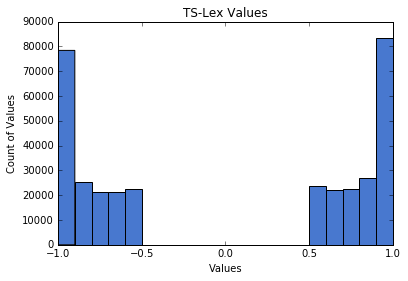

In [87]:
a = r.tslex.df.hist(bins=20, grid=False)[0][0]
a.set_title('TS-Lex Values')
a.set_xlabel('Values')
_ = a.set_ylabel('Count of Values')

### Best Model TSLex

In [78]:
tslex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_tslex = run_lex_test(r.tslex, verbose=True, **tslex_features)
pipe.pprint_results(ret_tslex)

[{'TSLEX_fpol': 1, 'TSLEX_posamt': 4, 'TSLEX_sum': 2.4436470000000003, 'TSLEX_min': -0.89356999999999998, 'TSLEX_max': 1.0, 'TSLEX_negamt': 1, 'TSLEX_avg': 0.48872940000000009}, {'TSLEX_fpol': -1, 'TSLEX_posamt': 1, 'TSLEX_sum': -1.91699, 'TSLEX_min': -1.0, 'TSLEX_max': 0.93985300000000005, 'TSLEX_negamt': 3, 'TSLEX_avg': -0.47924749999999999}, {'TSLEX_fpol': 1, 'TSLEX_posamt': 6, 'TSLEX_sum': 2.1756770000000003, 'TSLEX_min': -1.0, 'TSLEX_max': 0.94219200000000003, 'TSLEX_negamt': 3, 'TSLEX_avg': 0.24174188888888892}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [84]:
# teste bigrams and trigrams
tslex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True,
    'bigrams': True,
    'trigrams': False,
}
ret_tslex = run_lex_test(r.tslex, verbose=True, **tslex_features)
pipe.pprint_results(ret_tslex)

[{'TSLEX_fpol': 1, 'TSLEX_posamt': 4, 'TSLEX_sum': 2.4436470000000003, 'TSLEX_min': -0.89356999999999998, 'TSLEX_max': 1.0, 'TSLEX_negamt': 1, 'TSLEX_avg': 0.48872940000000009}, {'TSLEX_fpol': -1, 'TSLEX_posamt': 1, 'TSLEX_sum': -1.91699, 'TSLEX_min': -1.0, 'TSLEX_max': 0.93985300000000005, 'TSLEX_negamt': 3, 'TSLEX_avg': -0.47924749999999999}, {'TSLEX_fpol': 1, 'TSLEX_posamt': 5, 'TSLEX_sum': 1.6075499999999998, 'TSLEX_min': -1.0, 'TSLEX_max': 0.94219200000000003, 'TSLEX_negamt': 3, 'TSLEX_avg': 0.20094374999999998}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [79]:
ret_tslex = run_lex_test(r.tslex, verbose=True, negate=True, **tslex_features)
pipe.pprint_results(ret_tslex)

[{'TSLEX_fpol': 1, 'TSLEX_posamt': 4, 'TSLEX_sum': 2.4436470000000003, 'TSLEX_min': -0.89356999999999998, 'TSLEX_max': 1.0, 'TSLEX_negamt': 1, 'TSLEX_avg': 0.48872940000000009}, {'TSLEX_fpol': -1, 'TSLEX_posamt': 1, 'TSLEX_sum': -1.91699, 'TSLEX_min': -1.0, 'TSLEX_max': 0.93985300000000005, 'TSLEX_negamt': 3, 'TSLEX_avg': -0.47924749999999999}, {'TSLEX_fpol': -1, 'TSLEX_posamt': 4, 'TSLEX_sum': -1.8542520000000002, 'TSLEX_min': -1.0, 'TSLEX_max': 0.94219200000000003, 'TSLEX_negamt': 6, 'TSLEX_avg': -0.18542520000000001}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [80]:
tslex_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.tslex, **tslex_features) 

Final shape (8171, 840) (1405, 840)
train data, lex and final shape:  (8171, 927) (8171, 840) (8171, 1767)
test data, lex and final shape:  (1405, 927) (1405, 840) (1405, 1767)
Final shape (8171, 1679) (1405, 1679)
train data, lex and final shape:  (8171, 927) (8171, 1679) (8171, 2606)
test data, lex and final shape:  (1405, 927) (1405, 1679) (1405, 2606)
Final shape (8171, 2519) (1405, 2519)
train data, lex and final shape:  (8171, 927) (8171, 2519) (8171, 3446)
test data, lex and final shape:  (1405, 927) (1405, 2519) (1405, 3446)
Final shape (8171, 5039) (1405, 5039)
train data, lex and final shape:  (8171, 927) (8171, 5039) (8171, 5966)
test data, lex and final shape:  (1405, 927) (1405, 5039) (1405, 5966)
Final shape (8171, 16799) (1405, 16799)
train data, lex and final shape:  (8171, 927) (8171, 16799) (8171, 17726)
test data, lex and final shape:  (1405, 927) (1405, 16799) (1405, 17726)


In [248]:
tslex_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in tslex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_tslex = run_lex_test(r.tslex, verbose=True, join_char='_', **tmp)
    display(pipe.pprint_results(ret_tslex))

Testing key return_max
[{'TSLEX_max': 1.0}, {'TSLEX_max': 0.93985300000000005}, {'TSLEX_max': 0.94219200000000003}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_sum
[{'TSLEX_sum': 1.4583940000000002}, {'TSLEX_sum': -0.94339999999999979}, {'TSLEX_sum': 0.90236000000000005}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_avg
[{'TSLEX_avg': 0.36459850000000005}, {'TSLEX_avg': -0.31446666666666662}, {'TSLEX_avg': 0.18047200000000002}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_tokens
[{u'TSLEX_:)': 1.0, u'TSLEX_my': 0.504744, u'TSLEX_gas': -0.89357, u'TSLEX_!!!!': 0.84722}, {u'TSLEX_johnny': 0.939853, u'TSLEX_deal': -0.883253, u'TSLEX_shit': -1.0}, {u'TSLEX_nick': 0.942192, u'TSLEX_hate': -1.0, u'TSLEX_wait': 0.91723, u'TSLEX_fan': -0.538555, u'TSLEX_february': 0.581493}]
train data, lex and final shape:  (8171, 927) (8171, 6245) (8171, 7172)
test data, lex and final shape:  (1405, 927) (1405, 6245) (1405, 7172)


Testing key return_pol_amt
[{'TSLEX_negamt': 1, 'TSLEX_posamt': 3}, {'TSLEX_negamt': 2, 'TSLEX_posamt': 1}, {'TSLEX_negamt': 2, 'TSLEX_posamt': 3}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


Testing key final_pol
[{'TSLEX_fpol': 1}, {'TSLEX_fpol': -1}, {'TSLEX_fpol': 1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_min
[{'TSLEX_min': -0.89356999999999998}, {'TSLEX_min': -1.0}, {'TSLEX_min': -1.0}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


### MPQA

In [85]:
r.mpqa.df.sample(10)

,MPQA
fatuous,-1
leading,1
cumbersome,-1
dumbfound,-1
mordant,-1
daydream,1
strained,-1
utterances,0
liars,-1
richness,1


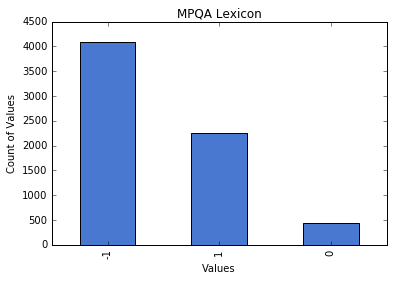

In [86]:
print_lex_hist(r.mpqa.df['MPQA'], 'MPQA Lexicon')

In [87]:
mpqa_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_mpqa = run_lex_test(r.mpqa, verbose=True, **mpqa_features)
pipe.pprint_results(ret_mpqa)

[{'MPQA_min': 0.0, 'MPQA_negamt': 0, 'MPQA_max': 0.0, 'MPQA_posamt': 0, 'MPQA_fpol': 0, 'MPQA_avg': 0.0, 'MPQA_sum': 0.0}, {'MPQA_min': 1, 'MPQA_negamt': 0, 'MPQA_max': 1, 'MPQA_posamt': 1, 'MPQA_fpol': 1, 'MPQA_avg': 1.0, 'MPQA_sum': 1}, {'MPQA_min': -1, 'MPQA_negamt': 1, 'MPQA_max': 1, 'MPQA_posamt': 1, 'MPQA_fpol': 0, 'MPQA_avg': 0.0, 'MPQA_sum': 0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


### Best Model MPQA

In [91]:
mpqa_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_mpqa = run_lex_test(r.mpqa, verbose=True, negate=True, **mpqa_features)
pipe.pprint_results(ret_mpqa)

[{'MPQA_min': 0.0, 'MPQA_negamt': 0, 'MPQA_max': 0.0, 'MPQA_posamt': 0, 'MPQA_fpol': 0, 'MPQA_avg': 0.0, 'MPQA_sum': 0.0}, {'MPQA_min': 1, 'MPQA_negamt': 0, 'MPQA_max': 1, 'MPQA_posamt': 1, 'MPQA_fpol': 1, 'MPQA_avg': 1.0, 'MPQA_sum': 1}, {'MPQA_min': -1, 'MPQA_negamt': 1, 'MPQA_max': 1, 'MPQA_posamt': 1, 'MPQA_fpol': 0, 'MPQA_avg': 0.0, 'MPQA_sum': 0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [89]:
mpqa_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.mpqa, negate=True, **mpqa_features) 

Final shape (8171, 82) (1405, 82)
train data, lex and final shape:  (8171, 927) (8171, 82) (8171, 1009)
test data, lex and final shape:  (1405, 927) (1405, 82) (1405, 1009)
Final shape (8171, 163) (1405, 163)
train data, lex and final shape:  (8171, 927) (8171, 163) (8171, 1090)
test data, lex and final shape:  (1405, 927) (1405, 163) (1405, 1090)
Final shape (8171, 246) (1405, 246)
train data, lex and final shape:  (8171, 927) (8171, 246) (8171, 1173)
test data, lex and final shape:  (1405, 927) (1405, 246) (1405, 1173)
Final shape (8171, 490) (1405, 490)
train data, lex and final shape:  (8171, 927) (8171, 490) (8171, 1417)
test data, lex and final shape:  (1405, 927) (1405, 490) (1405, 1417)
Final shape (8171, 1636) (1405, 1636)
train data, lex and final shape:  (8171, 927) (8171, 1636) (8171, 2563)
test data, lex and final shape:  (1405, 927) (1405, 1636) (1405, 2563)


In [254]:
mpqa_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in mpqa_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_mpqa = run_lex_test(r.mpqa, verbose=True, **tmp)
    display(pipe.pprint_results(ret_mpqa))

Testing key return_max
[{'MPQA_max': 0.0}, {'MPQA_max': 1}, {'MPQA_max': 1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_sum
[{'MPQA_sum': 0.0}, {'MPQA_sum': 1}, {'MPQA_sum': 0}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_avg
[{'MPQA_avg': 0.0}, {'MPQA_avg': 1.0}, {'MPQA_avg': 0.0}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_tokens
[{}, {u'MPQA_deal': 1}, {u'MPQA_hate': -1, u'MPQA_just': 1}]
train data, lex and final shape:  (8171, 927) (8171, 1367) (8171, 2294)
test data, lex and final shape:  (1405, 927) (1405, 1367) (1405, 2294)


Testing key return_pol_amt
[{'MPQA_posamt': 0, 'MPQA_negamt': 0}, {'MPQA_posamt': 1, 'MPQA_negamt': 0}, {'MPQA_posamt': 1, 'MPQA_negamt': 1}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


Testing key final_pol
[{'MPQA_fpol': 0}, {'MPQA_fpol': 1}, {'MPQA_fpol': 0}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_min
[{'MPQA_min': 0.0}, {'MPQA_min': 1}, {'MPQA_min': -1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


## SentiStrength

In [92]:
print(r.ss.df.shape)
r.ss.df.sample(10)

(2651, 1)


,SSTREN
perplex*,-2
hobble,-2
destruction,-2
sprightly,2
scorn*,-2
timid*,-2
lazy,-2
alibi*,-2
":,(",-1
liking,3


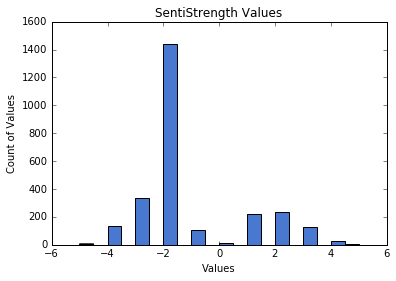

In [93]:
a = r.ss.df.hist(bins=20, grid=False)[0][0]
# print_lex_hist(r.ss.df['SSTREN'], 'SentiStrength Lexicon')
a.set_title('SentiStrength Values')
a.set_xlabel('Values')
_ = a.set_ylabel('Count of Values')

In [94]:
ss_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_ss = run_lex_test(r.ss, verbose=True, **ss_features)
pipe.pprint_results(ret_ss)

[{'SSTREN_fpol': 1, 'SSTREN_posamt': 1, 'SSTREN_avg': 1.0, 'SSTREN_sum': 1, 'SSTREN_negamt': 0, 'SSTREN_min': 1, 'SSTREN_max': 1}, {'SSTREN_fpol': 0, 'SSTREN_posamt': 0, 'SSTREN_avg': 0.0, 'SSTREN_sum': 0.0, 'SSTREN_negamt': 0, 'SSTREN_min': 0.0, 'SSTREN_max': 0.0}, {'SSTREN_fpol': -1, 'SSTREN_posamt': 0, 'SSTREN_avg': -4.0, 'SSTREN_sum': -4, 'SSTREN_negamt': 1, 'SSTREN_min': -4, 'SSTREN_max': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [95]:
ret_ss = run_lex_test(r.ss, verbose=True, negate=True, **ss_features)
pipe.pprint_results(ret_ss)

[{'SSTREN_fpol': 1, 'SSTREN_posamt': 1, 'SSTREN_avg': 1.0, 'SSTREN_sum': 1, 'SSTREN_negamt': 0, 'SSTREN_min': 1, 'SSTREN_max': 1}, {'SSTREN_fpol': 0, 'SSTREN_posamt': 0, 'SSTREN_avg': 0.0, 'SSTREN_sum': 0.0, 'SSTREN_negamt': 0, 'SSTREN_min': 0.0, 'SSTREN_max': 0.0}, {'SSTREN_fpol': -1, 'SSTREN_posamt': 0, 'SSTREN_avg': -4.0, 'SSTREN_sum': -4, 'SSTREN_negamt': 1, 'SSTREN_min': -4, 'SSTREN_max': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 7) (8171, 934)
test data, lex and final shape:  (1405, 927) (1405, 7) (1405, 934)


In [105]:
ss_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.ss, **ss_features)

Final shape (8171, 20) (1405, 20)
train data, lex and final shape:  (8171, 927) (8171, 20) (8171, 947)
test data, lex and final shape:  (1405, 927) (1405, 20) (1405, 947)
Final shape (8171, 39) (1405, 39)
train data, lex and final shape:  (8171, 927) (8171, 39) (8171, 966)
test data, lex and final shape:  (1405, 927) (1405, 39) (1405, 966)
Final shape (8171, 58) (1405, 58)
train data, lex and final shape:  (8171, 927) (8171, 58) (8171, 985)
test data, lex and final shape:  (1405, 927) (1405, 58) (1405, 985)
Final shape (8171, 115) (1405, 115)
train data, lex and final shape:  (8171, 927) (8171, 115) (8171, 1042)
test data, lex and final shape:  (1405, 927) (1405, 115) (1405, 1042)
Final shape (8171, 383) (1405, 383)
train data, lex and final shape:  (8171, 927) (8171, 383) (8171, 1310)
test data, lex and final shape:  (1405, 927) (1405, 383) (1405, 1310)


In [263]:
ss_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
compare_percentiles(r.ss, negate=True, **ss_features)

Final shape (8171, 24) (1405, 24)
train data, lex and final shape:  (8171, 927) (8171, 24) (8171, 951)
test data, lex and final shape:  (1405, 927) (1405, 24) (1405, 951)
Final shape (8171, 48) (1405, 48)
train data, lex and final shape:  (8171, 927) (8171, 48) (8171, 975)
test data, lex and final shape:  (1405, 927) (1405, 48) (1405, 975)
Final shape (8171, 72) (1405, 72)
train data, lex and final shape:  (8171, 927) (8171, 72) (8171, 999)
test data, lex and final shape:  (1405, 927) (1405, 72) (1405, 999)
Final shape (8171, 142) (1405, 142)
train data, lex and final shape:  (8171, 927) (8171, 142) (8171, 1069)
test data, lex and final shape:  (1405, 927) (1405, 142) (1405, 1069)
Final shape (8171, 476) (1405, 476)
train data, lex and final shape:  (8171, 927) (8171, 476) (8171, 1403)
test data, lex and final shape:  (1405, 927) (1405, 476) (1405, 1403)


In [96]:
ss_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in ss_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_ss = run_lex_test(r.ss, verbose=True, negate=True, **tmp)
    display(pipe.pprint_results(ret_ss))

Testing key return_max
[{'SSTREN_max': 1}, {'SSTREN_max': 0.0}, {'SSTREN_max': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_sum
[{'SSTREN_sum': 1}, {'SSTREN_sum': 0.0}, {'SSTREN_sum': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_avg
[{'SSTREN_avg': 1.0}, {'SSTREN_avg': 0.0}, {'SSTREN_avg': -4.0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_tokens
[{u'SSTREN_:)': 1}, {}, {u'SSTREN_hate': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 3850.0, 8171, 715.0, 1405)
Coverage train: 47.12%, test: 47.12%
train data, lex and final shape:  (8171, 927) (8171, 469) (8171, 1396)
test data, lex and final shape:  (1405, 927) (1405, 469) (1405, 1396)


Testing key return_pol_amt
[{'SSTREN_negamt': 0, 'SSTREN_posamt': 1}, {'SSTREN_negamt': 0, 'SSTREN_posamt': 0}, {'SSTREN_negamt': 1, 'SSTREN_posamt': 0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


Testing key final_pol
[{'SSTREN_fpol': 1}, {'SSTREN_fpol': 0}, {'SSTREN_fpol': -1}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_min
[{'SSTREN_min': 1}, {'SSTREN_min': 0.0}, {'SSTREN_min': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


### Best Model SStren

In [98]:
ss_features = {
    'return_tokens':False,
    'return_avg':False,
    'return_sum':False,
    'return_min':False,
    'return_max':True,
    'return_pol_amt':False,
    'final_pol':False   
}

# test all the keys, one by one
ret_ss = run_lex_test(r.ss, verbose=True, negate=True, **ss_features)
pipe.pprint_results(ret_ss)

[{'SSTREN_max': 1}, {'SSTREN_max': 0.0}, {'SSTREN_max': -4}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


In [264]:
ss_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in ss_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_ss = run_lex_test(r.ss, verbose=True, **tmp)
    display(pipe.pprint_results(ret_ss))

Testing key return_max
[{'SSTREN_max': 1}, {'SSTREN_max': 0.0}, {'SSTREN_max': -4}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_sum
[{'SSTREN_sum': 1}, {'SSTREN_sum': 0.0}, {'SSTREN_sum': -4}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_avg
[{'SSTREN_avg': 1.0}, {'SSTREN_avg': 0.0}, {'SSTREN_avg': -4.0}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_tokens
[{u'SSTREN_:)': 1}, {}, {u'SSTREN_hate': -4}]
train data, lex and final shape:  (8171, 927) (8171, 376) (8171, 1303)
test data, lex and final shape:  (1405, 927) (1405, 376) (1405, 1303)


Testing key return_pol_amt
[{'SSTREN_negamt': 0, 'SSTREN_posamt': 1}, {'SSTREN_negamt': 0, 'SSTREN_posamt': 0}, {'SSTREN_negamt': 1, 'SSTREN_posamt': 0}]
train data, lex and final shape:  (8171, 927) (8171, 2) (8171, 929)
test data, lex and final shape:  (1405, 927) (1405, 2) (1405, 929)


Testing key final_pol
[{'SSTREN_fpol': 1}, {'SSTREN_fpol': 0}, {'SSTREN_fpol': -1}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)


Testing key return_min
[{'SSTREN_min': 1}, {'SSTREN_min': 0.0}, {'SSTREN_min': -4}]
train data, lex and final shape:  (8171, 927) (8171, 1) (8171, 928)
test data, lex and final shape:  (1405, 927) (1405, 1) (1405, 928)
